# W207 Final Project - "Random Acts of Pizza"
### Predicting altruism through free pizza

#### Team Members: Gurdit Chahal, Shan He, Joanna Huang,  Emmy Lau

#### Table of Contents

1. Introduction
2. Exploratory Data Analysis
3. Baseline
4. Feature Engineering
5. Model Selection & Tuning
6. Error Analysis
7. Conclusion


### 1. Introduction

The Random Acts of Pizza subreddit is a place where people post and request free pizza from others on the Internet. In this project, our objective is to create an algorithm that predicts whether or not a request will receive pizza using the provided dataset of 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 201. Our final model is a combination of models trained on various textual and meta-data features, including information such as: time of the request, activity of the requester, and community-age of the requester.

#### Initialize packages and load in data

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import os
import string
import time
import datetime
from collections import Counter

# EDA plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.svm import LinearSVC as LSVC
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

from sklearn.decomposition import LatentDirichletAllocation as LDA
import lda
import gensim
from gensim import utils
import xgboost as xgb


/Users/shanhe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shanhe/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# os.chdir("/Users/gurditchahal/W207/coursework/Final_Project_Random_Acts/EDA")
# Read json file
train_json = json.load(open('train.json'))

# Normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# Extract output labels. 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# Read json file
test_json = json.load(open('test.json'))

# Normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

Train shape:  (4040, 32)
Test shape:  (1631, 17)


Based on the observed shapes of the two datasets, there appears to be a discrepancy with the training set having 32 columns and the test set only having 17. We take a closer look to better understand the reason behind this discrepancy.

In [3]:
# Print out columns that are only in the train dataset
train_only_columns = set(train_json_df.columns.values)-set(test_json_df.columns.values)
print("Columns in Train but not Test:\n",train_only_columns)

# Print out columns that are only in the test dataset
test_only_columns = set(test_json_df.columns.values)-set(train_json_df.columns.values)
print("\nColumns in Test but not Train:",test_only_columns)

Columns in Train but not Test:
 {'requester_account_age_in_days_at_retrieval', 'requester_number_of_posts_at_retrieval', 'number_of_downvotes_of_request_at_retrieval', 'requester_user_flair', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval', 'request_text', 'request_number_of_comments_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'requester_number_of_comments_at_retrieval', 'requester_number_of_posts_on_raop_at_retrieval', 'post_was_edited', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_upvotes_plus_downvotes_at_retrieval', 'requester_received_pizza'}

Columns in Test but not Train: set()


#### Details on the additional columns in the train set:

* request_text/post_was_edited: Since posts are often edited after a successful request, this request_text column is not the most accurate. Instead, request_text_edit_aware, which is available in both the train and test sets, will be used. This edit aware version of "request_text" strips edited comments indicating the success of the request.

* *_at_retrieval: For our purposes of real-time prediction, _at_request columns are more relevant.

* requester_user_flair: This is a post-receipt of pizza feature and thus will not be a useful indicator of results.

* requester_received_pizza: To be predicted

For these reasons, we will move forward with only the columns in both the train and test set. 

In [4]:
# Create new dataframe with only the shared columns
train_w_test = train_json_df[test_json_df.columns.values]

#### Split the training data into training data and dev data 
We will use 80% of our training data for exploratory data analysis, feature engineering and model training while the remaining 20% will be set aside as our development data set.

In [5]:
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_w_test, train_labels, test_size=0.2, random_state=12)


### 2. Exploratory Data Analysis
We'll first take a look at the non-text metadata.

In [6]:
train_data.describe()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,3232.000000,3232.000000,3232.00000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3.232000e+03,3.232000e+03
mean,256.662929,16.682342,116.69276,0.633045,21.387995,0.058787,18.383045,1141.690903,3536.765161,1.342819e+09,1.342816e+09
std,301.711688,72.319691,193.74547,3.274447,50.104315,0.305135,21.934935,2980.726140,17408.745325,2.327255e+07,2.327194e+07
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,1.306095e+09,1.306091e+09
25%,3.729690,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,1.320443e+09,1.320440e+09
50%,158.827159,0.000000,26.00000,0.000000,5.000000,0.000000,11.000000,177.500000,355.000000,1.342578e+09,1.342575e+09
75%,391.942080,0.000000,146.00000,0.000000,22.000000,0.000000,27.000000,1183.250000,2335.000000,1.364390e+09,1.364386e+09
max,2809.750787,785.457685,994.00000,88.000000,867.000000,5.000000,186.000000,87911.000000,789287.000000,1.381552e+09,1.381523e+09


Based on this initial look at the data, there doesn't appear to be anything unusual with the values. To extract more meaningful information around when the post was made, we will convert the unix_timestamp_of_request variable into a more interpretable form.

To understand the relationship between the features and whether or not a request is fulfilled, let's take a look at how the variables are correlated.

/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


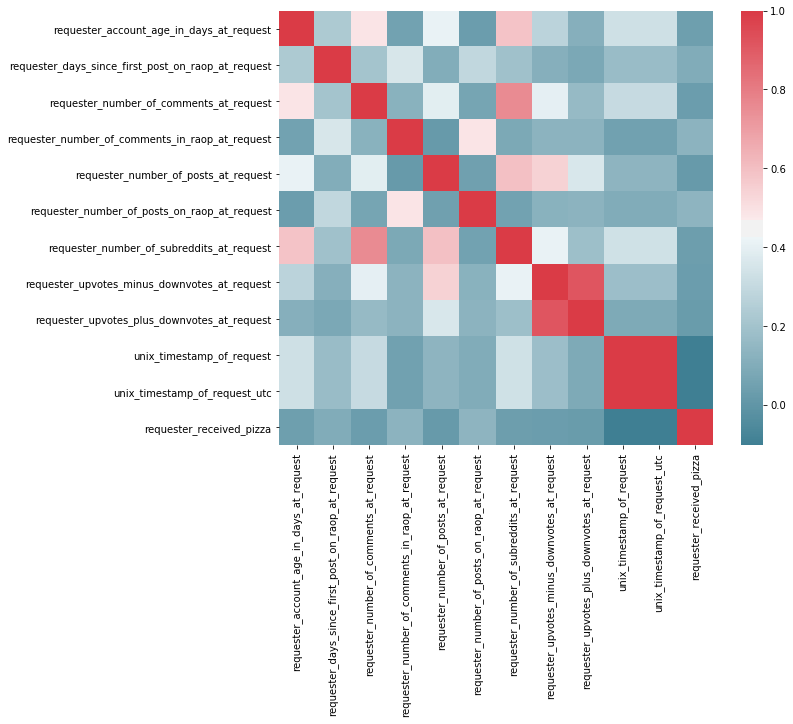

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
train_w_test['requester_received_pizza'] = train_json_df['requester_received_pizza']
corr = train_w_test.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Looking at the rightmost column, we can see how the features are related to requester_received_pizza. The following features seem to be most correlated and can be features to include when training our model: requester_account_age_in_days_at_request, requester_days_since_first_post_on_raop_at_request, requester_number_of_comments_in_raop_at_request, requester_number_of_posts_on_raop_at_request and unix_timestamp_of_request.

Next, we compare the features for fulfilled and unfulfilled requests.

In [8]:
fulfilled_requests = train_w_test.loc[train_w_test['requester_received_pizza']==True]
unfulfilled_requests = train_w_test.loc[train_w_test['requester_received_pizza']==False]

#### Request Time

In [9]:
# Extract day of week from request timestamp
train_w_test['datetime'] = pd.to_datetime(train_w_test["unix_timestamp_of_request"], unit = 's')
train_w_test['dayofweek'] = train_w_test['datetime'].dt.dayofweek

# See rate of fulfillment by day of week
fulfilled_dow = pd.DataFrame()
fulfilled_dow['dayofweek'] =[0,1,2,3,4,5,6]
fulfilled_dow['fulfilled_count'] = train_w_test[train_w_test['requester_received_pizza']==True]['dayofweek'].value_counts(sort=False)
fulfilled_dow['total_post_per_dow'] = train_w_test['dayofweek'].value_counts(sort=False)
fulfilled_dow['perc'] = round(fulfilled_dow['fulfilled_count']/fulfilled_dow['total_post_per_dow'],2)
del fulfilled_dow['fulfilled_count']
del fulfilled_dow['total_post_per_dow']
print(fulfilled_dow)

   dayofweek  perc
0          0  0.26
1          1  0.23
2          2  0.23
3          3  0.30
4          4  0.26
5          5  0.22
6          6  0.23


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Sunday, Wednesday and Thursday seem to have a higher rate of success by 1-8 percentage points. Thus, day of week is an important feature to include in our model.

In [10]:
train_w_test['hour']=train_w_test['datetime'].dt.hour

# See rate of fulfillment by hour
fulfilled_hour = pd.DataFrame()
fulfilled_hour['hour'] =range(24)
fulfilled_hour['fulfilled_count'] = train_w_test[train_w_test['requester_received_pizza']==True]['hour'].value_counts(sort=False)
fulfilled_hour['total_post_per_hour'] = train_w_test['hour'].value_counts(sort=False)
fulfilled_hour['perc'] = round(fulfilled_hour['fulfilled_count']/fulfilled_hour['total_post_per_hour'],2)
del fulfilled_hour['fulfilled_count']
del fulfilled_hour['total_post_per_hour']
print(fulfilled_hour.describe())

            hour       perc
count  24.000000  24.000000
mean   11.500000   0.232917
std     7.071068   0.062309
min     0.000000   0.120000
25%     5.750000   0.207500
50%    11.500000   0.230000
75%    17.250000   0.280000
max    23.000000   0.340000


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


With a fulfillment rate difference of 22% between the max and min of all hours, hour of day seems like an important feature to include in our model.

#### Requester Account and Activity

Now, let's take a look at the various requester feature differences between those whose requests were fulfilled, and those whose requests were not.

In [11]:
def fulfilled_or_not(feature):
    print(feature)
    print('Mean for Fulfilled Requests: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==True][feature].mean(),2)))
    print('Standard dev: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==True][feature].std(),2)))
    print('Mean for Unfulfilled Requests: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==False][feature].mean(),2)))
    print('Standard dev: ' + \
          str(round(train_w_test[train_w_test['requester_received_pizza']==False][feature].std(),2)))
    print('\n')

In [12]:
fulfilled_or_not('requester_account_age_in_days_at_request') 
fulfilled_or_not('requester_days_since_first_post_on_raop_at_request') 
fulfilled_or_not('requester_number_of_comments_at_request') 
fulfilled_or_not('requester_number_of_comments_in_raop_at_request') 
fulfilled_or_not('requester_number_of_posts_at_request') 
fulfilled_or_not('requester_number_of_posts_on_raop_at_request')

requester_account_age_in_days_at_request
Mean for Fulfilled Requests: 276.77
Standard dev: 312.79
Mean for Unfulfilled Requests: 247.35
Standard dev: 299.8


requester_days_since_first_post_on_raop_at_request
Mean for Fulfilled Requests: 28.56
Standard dev: 96.77
Mean for Unfulfilled Requests: 12.45
Standard dev: 59.19


requester_number_of_comments_at_request
Mean for Fulfilled Requests: 126.53
Standard dev: 202.33
Mean for Unfulfilled Requests: 111.37
Standard dev: 190.17


requester_number_of_comments_in_raop_at_request
Mean for Fulfilled Requests: 1.43
Standard dev: 5.91
Mean for Unfulfilled Requests: 0.39
Standard dev: 1.94


requester_number_of_posts_at_request
Mean for Fulfilled Requests: 23.44
Standard dev: 52.5
Mean for Unfulfilled Requests: 21.0
Standard dev: 50.35


requester_number_of_posts_on_raop_at_request
Mean for Fulfilled Requests: 0.14
Standard dev: 0.53
Mean for Unfulfilled Requests: 0.04
Standard dev: 0.22




#### Upvotes vs Downvotes

In [13]:
fulfilled_or_not('requester_upvotes_minus_downvotes_at_request')
fulfilled_or_not('requester_upvotes_plus_downvotes_at_request')

requester_upvotes_minus_downvotes_at_request
Mean for Fulfilled Requests: 1372.06
Standard dev: 5419.69
Mean for Unfulfilled Requests: 1090.9
Standard dev: 2956.58


requester_upvotes_plus_downvotes_at_request
Mean for Fulfilled Requests: 4923.7
Standard dev: 42166.37
Mean for Unfulfilled Requests: 3358.02
Standard dev: 17467.64




### Text Features

Next, we'll take a closer look at the text. To start, we can look at Non-Negative Matrix Factorization (NMF) for a better understanding of the request text topic breakdown.

In [14]:
from sklearn.decomposition import NMF
no_features = 1000
no_topics = 20
no_top_words = 10

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_data['request_text_edit_aware'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Print most common topics
topics_vec = np.argmax(nmf.transform(tfidf),axis=1)
imp_topics = Counter(topics_vec).most_common(5)
print('Top five most common topics with counts: ' + str(imp_topics))

# Derived topics with the top 10 words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("NMF Topics:\n")
display_topics(nmf, tfidf_feature_names, no_top_words)

Top five most common topics with counts: [(0, 1008), (1, 175), (3, 171), (2, 169), (11, 130)]
NMF Topics:

Topic 0:
ve job like pizza got work know new going don
Topic 1:
http com imgur jpg www reddit comments proof pic youtube
Topic 2:
love pizza tonight buy hut nice night craving pie like
Topic 3:
pay forward ll promise friday paycheck soon check gladly comes
Topic 4:
help need dinner appreciate willing feed asking tonight hoping kids
Topic 5:
really appreciate use pizza right don hey craving starving wednesday
Topic 6:
college student broke finals poor students kid studying summer appreciate
Topic 7:
money spent days buy tight pizza kind don right left
Topic 8:
hungry broke pretty super dont right sure feeling tomorrow roommates
Topic 9:
just want story sob pizza don craving moved sad need
Topic 10:
food house stamps today month need days dont family fridge
Topic 11:
week paid friday till don rent bank buy account end
Topic 12:
appreciated greatly pizza super thank picky weeks tomor

The top five topics can be generally described by the following:
- Topic 0: Job/Work
- Topic 1: Inclusion of proof
- Topic 2: Love/Craving
- Topic 3: Promise of reciprocity
- Topic 11: Money/Rent

#### Word Vizualization

Next we dive a little deeper, looking at the common phrases within the posts and the differences between fulfilled and unfulfilled requests.

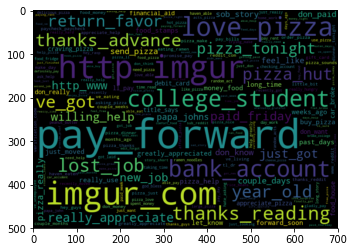

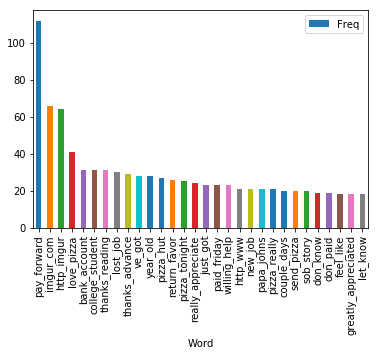

In [15]:
def word_join(string,joiner='_'):
    return joiner.join(string.split()) 
v_join=np.vectorize(word_join)

CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==1]['request_text_edit_aware'])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=dict(zip(vocab,freqs))
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
word_score2=sorted(list(zip(vocab,freqs)), key=lambda x: -x[1])
got_pizza=pd.DataFrame(word_score2[:30],columns = ['Word', 'Freq'])
got_pizza.plot.bar(x='Word',y='Freq')

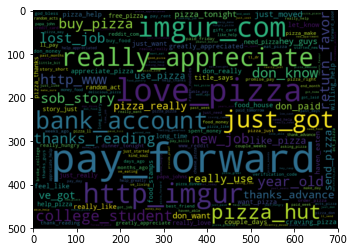

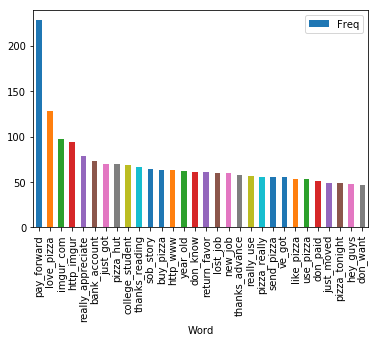

In [16]:
CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==0]['request_text_edit_aware'])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=dict(zip(vocab,freqs))
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
word_score2=list(zip(vocab,freqs))
word_score2=sorted(word_score2, key=lambda x: -x[1])
no_pizza=pd.DataFrame(word_score2[:30],columns = ['Word', 'Freq'])
no_pizza.plot.bar(x='Word',y='Freq')

We chose bigrams as unigrams alone made little sense and trigrams were too rare to be useful. From these visuals we can start to get an idea of potential differentiatiors in terms of post content that might make a difference to whether a user gets pizza or not. There are some interesting differences such as Redditors getting the pizza talking about "lost job" vs those not saying "new job". Even amongst common phrases, what's interesting is how those who didn't get pizza mentioned "love pizza" and "pay forward" more often.

### 3. Baseline

As a baseline, we have chosen the Naive Bayes model combined with a bag of words approach since Naive Bayes is the most straightforward modeling approach to take in terms of model assumptions (feature independence) and complexity. Furthermore, Naive Bayes works well with text as word counts are natural features for Naive Bayes since we calculate probabilities from observation counts.

In [17]:
# Use standard CountVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer() 
train_bag_of_words = vectorizer.fit_transform(train_data['request_text_edit_aware'])
dev_bag_of_words = vectorizer.transform(dev_data['request_text_edit_aware'])

# Create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters)
    
# train the MultinomialNB
clf.fit(train_bag_of_words, train_labels)

pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))

{'alpha': 8.789090909090909}
auc score using CountVectorizer & MultinomialNB = 0.5988939144736842


 We see with an auc of .598, our baseline does better than randomly guessing (auc of .5) but not by too much.

### Feature Engineering

We begin by prepping our text data, creating a new column "post_and_title" that combines all the relevant text fields (title of post and body of post).

In [18]:
train_data['post_and_title']=train_data['request_text_edit_aware'] +' '+train_data['request_title']
dev_data['post_and_title']=dev_data['request_text_edit_aware'] +' '+dev_data['request_title']

/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In preparation of further processing, we will preprocess our text in the following ways: converting all text to lowercase, removing punctuation, non-alphanumeric characters and extra spaces. 

In [19]:
#from nltk.stem import SnowballStemmer
def pre_process(s):
    s = re.sub("[^\w']|_", " ", s) 
    s=s.translate(str.maketrans(' ',' ',string.punctuation))# Strip punctuation before looking
    s= re.sub(' +',' ', s) # Remove extra spaces
    s=s.lower()
    #s = ' '.join(word[:6] if len(word)>6 else word 
                        # for word in s.split()) # Shorten long words
    #s = re.sub(r'\b\d+\b', r' ', s) # Replace sequences of numbers with a single token
    
    #s_stemmer = SnowballStemmer('english')
    #s = ' '.join([s_stemmer.stem(i) for i in s.split()])
    return s


Borrowing from the Stanford paper regarding narratives found in the posts, we create features that identify words for each narrative in a given observation and calculate the feature for each narrative as a total count of the words in a given narrative in the text and divide by total text length.

In [20]:
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]

def find_narr(narr,s):
    ct=0
    for word in narr:
        ct+=s.split().count(word)
    return ct/len(s.split())

def construct_narrative_features(data): 
    
    data['post_and_title'] = data['request_text_edit_aware'] + ' ' + data['request_title']
    clean_text = data['post_and_title'].apply(lambda s: pre_process(s))

    features = pd.DataFrame()

    for n in narratives:
        features[n[0]] = clean_text.apply(lambda s: find_narr(n,s))
    return features

train_narrative_features = construct_narrative_features(train_data)
dev_narrative_features = construct_narrative_features(dev_data)

/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Create a function extract the seasonality information from our post metadata.

In [21]:
#https://www.timeanddate.com/calendar/aboutseasons.html
def ts_to_season(month):
    if month>=3 and month<=5:
        return "spring"
    elif month>=6 and month <=8:
        return "summer"
    elif month>=9 and month <=11:
        return "fall"
    else:
        return "winter"

Create features for both train and dev set to leverage the metadata provided within the dataset.

In [22]:
def construct_ft_mat(data):
    feat_mat=pd.DataFrame()
    
    # Extract temporal features
    feat_mat['hour_request']=pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's').dt.hour
    feat_mat['day_request']=pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's').dt.day
    feat_mat['day_request']=feat_mat['day_request'].apply(lambda x: 0 if x<16 else 1)
    feat_mat['season_request']=pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's').dt.month
    feat_mat['season_request']=feat_mat['season_request'].apply(ts_to_season)
    feat_mat['is_spring']=feat_mat['season_request'].apply(lambda x: 1 if x=='spring' else 0)
    feat_mat['is_summer']=feat_mat['season_request'].apply(lambda x: 1 if x=='summer' else 0)
    feat_mat['is_fall']=feat_mat['season_request'].apply(lambda x: 1 if x=='fall' else 0)
    feat_mat['is_winter']=feat_mat['season_request'].apply(lambda x: 1 if x=='winter' else 0)
    del feat_mat['season_request']
    
    # Extract post popularity features
    feat_mat['first_post']=np.log(data['requester_days_since_first_post_on_raop_at_request']+1)
    feat_mat['upvotes_minus_downvotes']=data['requester_upvotes_minus_downvotes_at_request']
    feat_mat['upvotes_plus_downvotes_at_request']=np.log(data['requester_upvotes_plus_downvotes_at_request']+1)
    upvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request'] + row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    downvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request']- row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    feat_mat['upvotes']=upvotes
    feat_mat['vote_ratio']=upvotes/(upvotes+downvotes+1)
    
    # Extract requester features
    feat_mat['req_age']=np.log(data['requester_account_age_in_days_at_request']+1)
    feat_mat['num_subs']=np.log(data['requester_number_of_subreddits_at_request']+1)
    feat_mat['num_posts_req']=np.log(data['requester_number_of_posts_at_request']+1)
    feat_mat['pizza_activity']=np.log(data['requester_number_of_posts_on_raop_at_request']+1)
    feat_mat['num_pizza_comments']=np.log(data['requester_number_of_comments_in_raop_at_request']+1)
    feat_mat['community_age'] = (pd.to_datetime(data['unix_timestamp_of_request_utc'],utc = True, unit = 's') - \
                                pd.to_datetime('2010-12-8', format='%Y-%m-%d',utc=True)).astype('timedelta64[D]')
    
    feat_mat['community_age'] = (feat_mat['community_age'] * 10./feat_mat['community_age'].max()).astype(int)    
    
    #feat_mat['karma']=(train_data['requester_upvotes_minus_downvotes_at_request']* 10.\
                                         #/train_data.requester_upvotes_minus_downvotes_at_request.max()).astype(int)

    #feat_mat['posted_in_raop_before']= (train_data['requester_number_of_posts_on_raop_at_request'] > 0).astype(int)
    
    #feat_mat['posted_before']= (train_data['requester_number_of_posts_at_request'] > 0).astype(int)
    
    
    # Extract post features
    feat_mat['len_request']=np.log(data['request_text_edit_aware'].apply(len)+1)
    feat_mat['len_title']=np.log(data['request_title'].apply(len)+1)
    feat_mat['reciprocity'] = data['post_and_title'].apply(lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor", x) 
                                               else 0)
    feat_mat['image_in_text'] = data['post_and_title'].str.contains('imgur.com|.jpg|.png|.jpeg', case=False).apply(lambda x: 1 if x else 0)
    feat_mat['politeness'] = data['post_and_title'].apply(lambda x: 1 if re.search("thank|appreciate|advance", x) else 0)
    
    # Extract narrative features
    #craving = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
    #family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
    #job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
    #money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|credit|budget|day|now| \
        #time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
    #student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
    #gratitude = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE)
    # ratio of narrative words to length of full word
    #feat_mat['money'] = train_data['full_text'].apply(lambda x: len(money.findall(x))/len(x.split()))
    #feat_mat['job'] = train_data['full_text'].apply(lambda x: len(job.findall(x))/len(x.split()))
    #feat_mat['student'] = train_data['full_text'].apply(lambda x: len(student.findall(x))/len(x.split()))
    #feat_mat['family'] = train_data['full_text'].apply(lambda x: len(family.findall(x))/len(x.split()))
    #feat_mat['craving'] = train_data['full_text'].apply(lambda x: len(craving.findall(x))/len(x.split()))
    return feat_mat

feat_mat=construct_ft_mat(train_data)
dev_mat=construct_ft_mat(dev_data)

In [23]:
# Convert dataframe to a numpy-array representation.
train_ft_mat=feat_mat.as_matrix()
dev_ft_mat=dev_mat.as_matrix()

In [24]:
# Extract text features from the post text by generating features from words
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=pre_process,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_data['post_and_title'])
dev_bag_of_words = vectorizer.transform(dev_data['post_and_title'])

In [25]:
#Use linear svm with l1 penalty to feature select from our bag of words in order to reduce dimension.
lsvc = LSVC(C=.85, penalty="l1", dual=False,random_state=42).fit(train_bag_of_words,train_labels)
model = SelectFromModel(lsvc, prefit=True)

train_pruned_bow = model.transform(train_bag_of_words)
print(train_pruned_bow.shape)

dev_pruned_bow=model.transform(dev_bag_of_words)

(3232, 873)


In [26]:
vectorizer_lda = CountVectorizer(min_df=10,ngram_range=(1,1), preprocessor=pre_process,stop_words='english') 
lda_bag_of_words = vectorizer_lda.fit_transform(train_data['post_and_title'])
lda_devbag_of_words = vectorizer_lda.transform(dev_data['post_and_title'])

In [27]:
# LDA tells us what topics are present in any given document by observing all the words 
# in it and producing a topic distribution

lda = LDA(n_components = 3, learning_method="batch", max_iter=30,learning_decay=.7, random_state=42)
train_topics = lda.fit_transform(lda_bag_of_words)
print(lda.components_.shape)

dev_topics=lda.transform(lda_devbag_of_words)

(3, 1580)


In [28]:
from sklearn.decomposition import NMF
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_data['post_and_title'])
dev_tfidf = tfidf_vectorizer.transform(dev_data['post_and_title'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 3

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_train = nmf_model.transform(tfidf)
nmf_dev = nmf_model.transform(dev_tfidf)

In [29]:
train_combined=hstack([train_pruned_bow,train_ft_mat,train_topics, train_narrative_features,nmf_train])
dev_combined=hstack([dev_pruned_bow,dev_ft_mat,dev_topics, dev_narrative_features,nmf_dev ])

First natural step is to see if we improved from baseline from providing additional features. We note that naturally these features don't translate to the theory of Naive Bayes as we don't have frequency counts, positive numbers, etc. Moreover, what meaning is in the features is likely lost as we have to take absolute value of the values in order to even feed into the model.

In [30]:
# Create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters,scoring='roc_auc')
    
# train the MultinomialNB
clf.fit(np.abs(train_combined), train_labels)

pred_dev_prob = clf.predict_proba(np.abs(dev_combined))[:,0]

print(clf.best_params_)
print("auc score using combined features & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))

{'alpha': 0.01}
auc score using combined features & MultinomialNB = 0.44980674342105265


We see that we actually perform worse than baseline, in fact worse than random guessing! This guides us to move forward in looking to a different model to make use of these new features. We turn to Gaussian Naive Bayes as it can accept real values. We set the priors to reflect the imbalance in the the set.

In [31]:
from sklearn.naive_bayes import GaussianNB

gnb=GaussianNB(priors=[0.6, 0.4])
gnb.fit(train_combined.toarray(),train_labels)
pred_dev=gnb.predict(dev_combined.toarray())
print("auc score using combined features & GaussianNB = {}".format(roc_auc_score(dev_labels, pred_dev, average='micro')))


auc score using combined features & GaussianNB = 0.5980592105263158


We do comparable to baseline in this case and are pushed to look further than these simpler methods. 

We take a step up and look to Logistic Regression as our linear classifier of choice.

In [32]:
lr = LogisticRegression()
#parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(0.0005, 0.1, 100)}
clf = GridSearchCV(lr, parameters,cv=5)
clf.fit(train_combined, train_labels)
pred_dev_prob = clf.predict_proba(dev_combined)[:,1]
pred_dev_labels = clf.predict(dev_combined)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.1}


0.6876398026315789

We see a significant boost in auc via logistic regression. This is likely due to the fact that we have reduced the assumptions/constraints to our features (haven't assumed a particular distribution besides non-multicolinearity and independence of features). From prior experience (project 2), we also know that this model is prone to overfitting when data is "small".

We move forward with a non-linear method, the xgboost variant of gradient boosting, to capture higher level interactions in variables. Moreover, we can somewhat treat feature independence and possible multi-collinearity due to the way in that the ensembling method subsets both features and samples from the data.

In terms of the parameters, we can think of them as a balance between preventing overfitting while also capturing as much predictive power as possible. We try to gain predictive power by increasing the depth so that the subsequent trees can fit tightly on the residuals and scale the weight attributed to the samples (3.06) as observed by the imbalance in our data (ratio of those who didn't get pizza to those who did). We subsample the training set so that there is further prevention of overfitting, and subsample the features so that multi-colliniearity can have a weaker role.

In [33]:
#create dmatrices
dtrain = xgb.DMatrix(train_combined, train_labels)
ddev = xgb.DMatrix(dev_combined
                         , dev_labels)

#booster parameter
param = {'max_depth':5, 'eta': .0188, 'silent': 1, 'objective': 'binary:logistic'
         , 'scale_pos_weight': 3.06,'max_delta_step':1,'subsample':.70,'n_estimators':128,'colsample_bytree':.7,'seed':42}
param['nthread'] = 4
param['eval_metric'] = 'auc'

#specify validation set to watch performance
evallist = [(ddev, 'eval'), (dtrain, 'train')]

#train model
num_round = 100
bst = xgb.train(param.items(), dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-auc:0.644005	train-auc:0.700189
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.666184	train-auc:0.755109
[2]	eval-auc:0.67345	train-auc:0.768954
[3]	eval-auc:0.678088	train-auc:0.777399
[4]	eval-auc:0.682286	train-auc:0.790649
[5]	eval-auc:0.677208	train-auc:0.79421
[6]	eval-auc:0.67919	train-auc:0.796986
[7]	eval-auc:0.67595	train-auc:0.80099
[8]	eval-auc:0.669211	train-auc:0.802725
[9]	eval-auc:0.669486	train-auc:0.808543
[10]	eval-auc:0.668639	train-auc:0.808494
[11]	eval-auc:0.664289	train-auc:0.811255
[12]	eval-auc:0.661316	train-auc:0.813064
[13]	eval-auc:0.660827	train-auc:0.817749
[14]	eval-auc:0.661756	train-auc:0.819076
[15]	eval-auc:0.660415	train-auc:0.819366
[16]	eval-auc:0.662578	train-auc:0.818695
[17]	eval-auc:0.665107	train-auc:0.822023
[18]	eval-auc:0.667052	train-auc:0.823497
[19]	eval-auc:0.666357	train-auc:0.825519
[20]	eval-auc:0.662919	train-auc

We see an improvement in terms of score, though not by a wide margin. We could either do further hyperparameter tuning on the model as there are plenty of knobs to play with as well as go back to the drawing board for feature selection. Since this model performed the best in terms of performance and we aren't going for parsimony as much as predictive power, we select this model as our candidate for the test set.

### 7. Error Analysis

**6.1 Model Submission, Score, and Ranking**

In [34]:
#construct features for test data
test_data = test_json_df
test_data['post_and_title'] = test_data['request_text_edit_aware'] +' '+test_data['request_title']
test_narrative_features = construct_narrative_features(test_data)
test_mat = construct_ft_mat(test_data)
test_ft_mat = test_mat.as_matrix()
test_bag_of_words = vectorizer.transform(test_data['post_and_title'])
test_pruned_bow=model.transform(test_bag_of_words)
lda_testbag_of_words = vectorizer_lda.transform(test_data['post_and_title'])
test_topics = lda.transform(lda_testbag_of_words)
test_tfidf = tfidf_vectorizer.transform(test_data['post_and_title'])
nmf_test = nmf_model.transform(test_tfidf)
test_combined=hstack([test_pruned_bow,test_ft_mat,test_topics, test_narrative_features,nmf_test])

In [35]:
#Make predictions for test data
dtest = xgb.DMatrix(test_combined)
final_pred = bst.predict(dtest, ntree_limit=bst.best_iteration)
(final_pred > 0.5).astype(int).sum()
# final_pred.shape

556

**6.2 Submission**

In [36]:
submssion = pd.DataFrame(np.vstack((test_data.request_id, (final_pred > 0.45).astype(int))).T)
submssion.columns = ["request_id", "requester_received_pizza"]
submssion.set_index('request_id', inplace = True)
# submssion.head(5)
submssion.to_csv('Submission.csv')

Our submission on Kaggle scored **0.63892** (AUC) and is good for **186th** place at the time of writing. 

**6.3 ROC Curve**

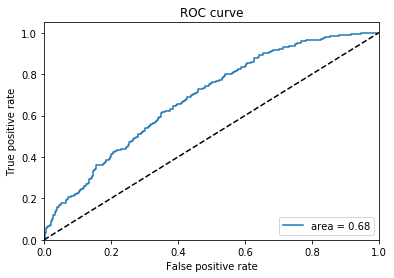

In [37]:
#Create ROC curve using Dev data
from sklearn.metrics import roc_curve, auc

pred_probas = bst.predict(ddev, ntree_limit=bst.best_iteration)

fpr,tpr,_ = roc_curve(dev_labels, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.show()

**6.4 Learning Curve**

In [58]:
#iterate models over increasing training size
xgbooster = xgb.XGBClassifier(missing=np.nan
                    , max_depth=5
                    , eta= .0188
                    , silent= 1
                    , verbose = 0 #silent iteration
                    , objective= 'binary:logistic'
                    , scale_pos_weight= 3.06
                    , max_delta_step=1
                    , subsample=.70
                    , n_estimators=128
                    , colsample_bytree=.7
                     ,seed=42)

scorestrain=[]
scorescv=[]
iterations=[]

for i in range(400,len(train_labels),100) :                
    print(i)
    xgbooster.fit(train_combined.tocsc()[:i], train_labels[:i], early_stopping_rounds=10, eval_metric="auc",
    eval_set=[(dev_combined, dev_labels)])
    scorestrain.append(roc_auc_score(train_labels[:i], xgbooster.predict_proba(train_combined.tocsc()[:i], ntree_limit=xgbooster.best_iteration)[:,1]))
    scorescv.append(roc_auc_score(dev_labels,xgbooster.predict_proba(dev_combined,ntree_limit=xgbooster.best_iteration)[:,1]))
    iterations.append(i)


400
[0]	validation_0-auc:0.538392
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.575292
[2]	validation_0-auc:0.598146
[3]	validation_0-auc:0.603635
[4]	validation_0-auc:0.607632
[5]	validation_0-auc:0.61523
[6]	validation_0-auc:0.616452
[7]	validation_0-auc:0.634034
[8]	validation_0-auc:0.631916
[9]	validation_0-auc:0.631887
[10]	validation_0-auc:0.637072
[11]	validation_0-auc:0.641887
[12]	validation_0-auc:0.641859
[13]	validation_0-auc:0.641102
[14]	validation_0-auc:0.63278
[15]	validation_0-auc:0.637356
[16]	validation_0-auc:0.63361
[17]	validation_0-auc:0.631254
[18]	validation_0-auc:0.632644
[19]	validation_0-auc:0.625761
[20]	validation_0-auc:0.629963
[21]	validation_0-auc:0.63051
Stopping. Best iteration:
[11]	validation_0-auc:0.641887

500
[0]	validation_0-auc:0.546406
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.579017
[2]	validation_0-auc:0.601706
[3]	validation_0-auc:0.602627
[4]	validation_0-a

[13]	validation_0-auc:0.637171
[14]	validation_0-auc:0.641053
[15]	validation_0-auc:0.643154
[16]	validation_0-auc:0.648729
[17]	validation_0-auc:0.64859
[18]	validation_0-auc:0.648343
[19]	validation_0-auc:0.647739
[20]	validation_0-auc:0.652459
[21]	validation_0-auc:0.650921
[22]	validation_0-auc:0.651735
[23]	validation_0-auc:0.651316
[24]	validation_0-auc:0.651316
[25]	validation_0-auc:0.651102
[26]	validation_0-auc:0.652056
[27]	validation_0-auc:0.648717
[28]	validation_0-auc:0.64435
[29]	validation_0-auc:0.642664
[30]	validation_0-auc:0.640428
Stopping. Best iteration:
[20]	validation_0-auc:0.652459

1300
[0]	validation_0-auc:0.584844
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.601201
[2]	validation_0-auc:0.612455
[3]	validation_0-auc:0.605999
[4]	validation_0-auc:0.616328
[5]	validation_0-auc:0.625547
[6]	validation_0-auc:0.621476
[7]	validation_0-auc:0.626805
[8]	validation_0-auc:0.634535
[9]	validation_0-auc:0.640177
[10]	validation_0

[15]	validation_0-auc:0.665646
[16]	validation_0-auc:0.669272
[17]	validation_0-auc:0.669889
[18]	validation_0-auc:0.674947
[19]	validation_0-auc:0.675621
[20]	validation_0-auc:0.67359
[21]	validation_0-auc:0.67368
[22]	validation_0-auc:0.672348
[23]	validation_0-auc:0.669864
[24]	validation_0-auc:0.675806
[25]	validation_0-auc:0.676406
[26]	validation_0-auc:0.676916
[27]	validation_0-auc:0.67676
[28]	validation_0-auc:0.671308
[29]	validation_0-auc:0.669918
[30]	validation_0-auc:0.668914
[31]	validation_0-auc:0.666727
[32]	validation_0-auc:0.669539
[33]	validation_0-auc:0.672171
[34]	validation_0-auc:0.671826
[35]	validation_0-auc:0.670066
[36]	validation_0-auc:0.669087
Stopping. Best iteration:
[26]	validation_0-auc:0.676916

2000
[0]	validation_0-auc:0.585251
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.599737
[2]	validation_0-auc:0.614667
[3]	validation_0-auc:0.627377
[4]	validation_0-auc:0.633647
[5]	validation_0-auc:0.635514
[6]	validation

[2]	validation_0-auc:0.624926
[3]	validation_0-auc:0.630148
[4]	validation_0-auc:0.634412
[5]	validation_0-auc:0.638803
[6]	validation_0-auc:0.643812
[7]	validation_0-auc:0.64493
[8]	validation_0-auc:0.646266
[9]	validation_0-auc:0.651669
[10]	validation_0-auc:0.654256
[11]	validation_0-auc:0.654819
[12]	validation_0-auc:0.649169
[13]	validation_0-auc:0.650016
[14]	validation_0-auc:0.650666
[15]	validation_0-auc:0.651077
[16]	validation_0-auc:0.651102
[17]	validation_0-auc:0.654038
[18]	validation_0-auc:0.654137
[19]	validation_0-auc:0.651554
[20]	validation_0-auc:0.650066
[21]	validation_0-auc:0.651151
Stopping. Best iteration:
[11]	validation_0-auc:0.654819

2700
[0]	validation_0-auc:0.586583
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.602237
[2]	validation_0-auc:0.59009
[3]	validation_0-auc:0.594585
[4]	validation_0-auc:0.618557
[5]	validation_0-auc:0.62822
[6]	validation_0-auc:0.629786
[7]	validation_0-auc:0.636772
[8]	validation_0-auc:0.6

[55]	validation_0-auc:0.689359
[56]	validation_0-auc:0.690206
[57]	validation_0-auc:0.691061
[58]	validation_0-auc:0.691217
[59]	validation_0-auc:0.69153
[60]	validation_0-auc:0.693528
[61]	validation_0-auc:0.69315
[62]	validation_0-auc:0.691933
[63]	validation_0-auc:0.693923
[64]	validation_0-auc:0.692804
[65]	validation_0-auc:0.692681
[66]	validation_0-auc:0.692911
[67]	validation_0-auc:0.693898
[68]	validation_0-auc:0.693503
[69]	validation_0-auc:0.693117
[70]	validation_0-auc:0.695066
[71]	validation_0-auc:0.691974
[72]	validation_0-auc:0.691176
[73]	validation_0-auc:0.690724
[74]	validation_0-auc:0.690403
[75]	validation_0-auc:0.690033
[76]	validation_0-auc:0.689646
[77]	validation_0-auc:0.689622
[78]	validation_0-auc:0.690271
[79]	validation_0-auc:0.690518
[80]	validation_0-auc:0.691546
Stopping. Best iteration:
[70]	validation_0-auc:0.695066

3100
[0]	validation_0-auc:0.584918
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.595646
[2]	valid

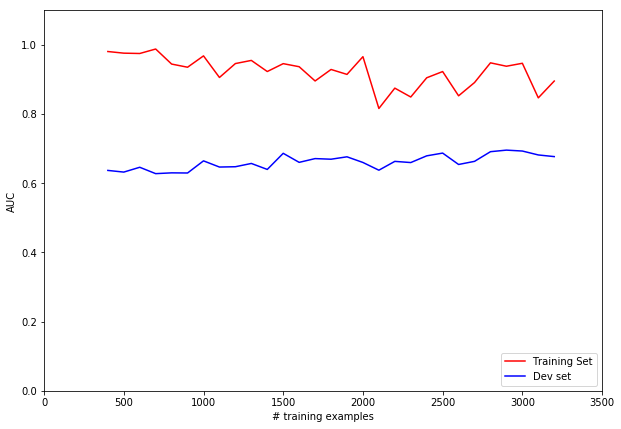

In [39]:
#plot training curve
plt.figure(figsize=(10,7))
plt.plot(iterations,scorestrain,'r')
plt.plot(iterations,scorescv, 'b')
plt.ylim(0,1.1)
plt.xlim(0,3500)
plt.xlabel('# training examples')
plt.ylabel('AUC')
plt.legend(['Training Set','Dev set'],loc='lower right')

From the learning curve plotted above, we see that the model we chose had some overfitting but the AUC performance on the dev set does benefit from increasing number of training samples. Moreover, the learning curves for the training set and the dev set are still far from converging. We'd expect a higher AUC if we are able to gather a larger training size.

**6.5 Missing features for test text features**

In [54]:
TV = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=pre_process,stop_words='english',norm='l2',sublinear_tf=True)
test_set = set(TV.fit(test_data['post_and_title']).vocabulary_.keys())
train_set = set(TV.fit(train_data['post_and_title']).vocabulary_.keys())

print (round((len(test_set - train_set) / len(test_set) * 100), 2), 'percent of the test set vocabulary is missing from the training set') 

7.37 percent of the test set vocabulary is missing from the training set


### 7. Conclusion